In [ ]:
# duplicar as últimas amostras
# rodar o melhor modelo do tempo para predição de SST e firmeza e montar tabela

In [58]:
import cv2
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import math

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold

%load_ext autoreload

sys.path.append(os.getcwd()+'//..//scripts//')
path = os.getcwd() + '//..//'

from MNG import MNG
from MNGFeatures import MNGFeatures
from MNGFeaturesMeans import MNGFeaturesMeans
from MNGFeaturesSize import MNGFeaturesSize
from MNGModel import MNGModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# repetindo os últimos dados

In [119]:
# data_path = os.getcwd()+'/../resampling/all_data_repeated.csv'
data_path = os.getcwd()+'/../resampling/all_data_synthetic.csv'
old_data = pd.read_csv(data_path, sep=',', index_col=0)

In [92]:
# run this once
# repeated_list_indexes = np.arange(480)
# random.shuffle(repeated_list_indexes)
# to_be_deleted = repeated_list_indexes[:120].tolist()

In [ ]:
# to_be_deleted = [202, 204, 121, 158, 393, 478, 471, 36, 56, 371, 178, 337, 299, 410, 59, 153, 282, 119, 210, 320, \
#                  214, 327, 391, 475, 297, 335, 312, 110, 349, 425, 183, 47, 256, 405, 23, 473, 192, 228, 279, 72, \
#                  470, 71, 236, 81, 238, 304, 1, 466, 455, 92, 430, 171, 126, 329, 345, 127, 406, 370, 207, 80, 168,\
#                  359, 5, 399, 167, 150, 267, 277, 303, 368, 61, 116, 333, 188, 276, 351, 306, 20, 441, 248, 115, \
#                  101, 280, 32, 100, 46, 109, 379, 182, 224, 413, 472, 253, 123, 184, 339, 464, 22, 325, 190, 465, \
#                  428, 174, 193, 3, 245, 197, 412, 386, 78, 328, 344, 76, 334, 63, 219, 361, 448, 87, 377]

In [123]:
# ATTENTION! I'M ASSIGNING IT MANUALLY, NOT BASED IN INDEX
repeated_data = old_data.iloc[-480:]
rows_to_delete = repeated_data.iloc[to_be_deleted]

data = old_data.drop(rows_to_delete.index.values)

# remove atributos diff
data = data.drop(columns=data.columns.values[:1710])

In [124]:
data.shape

(1200, 228)

In [127]:
teste = data[['height', 'width', 'area', 'diameter', 'bcd', 'cd', 'dd', 'sst', 'firmeza', 'time', 'mean_R_full'\
             ,'mean_G_full', 'mean_B_full', 'massa', 'ratio', 'acidez']]

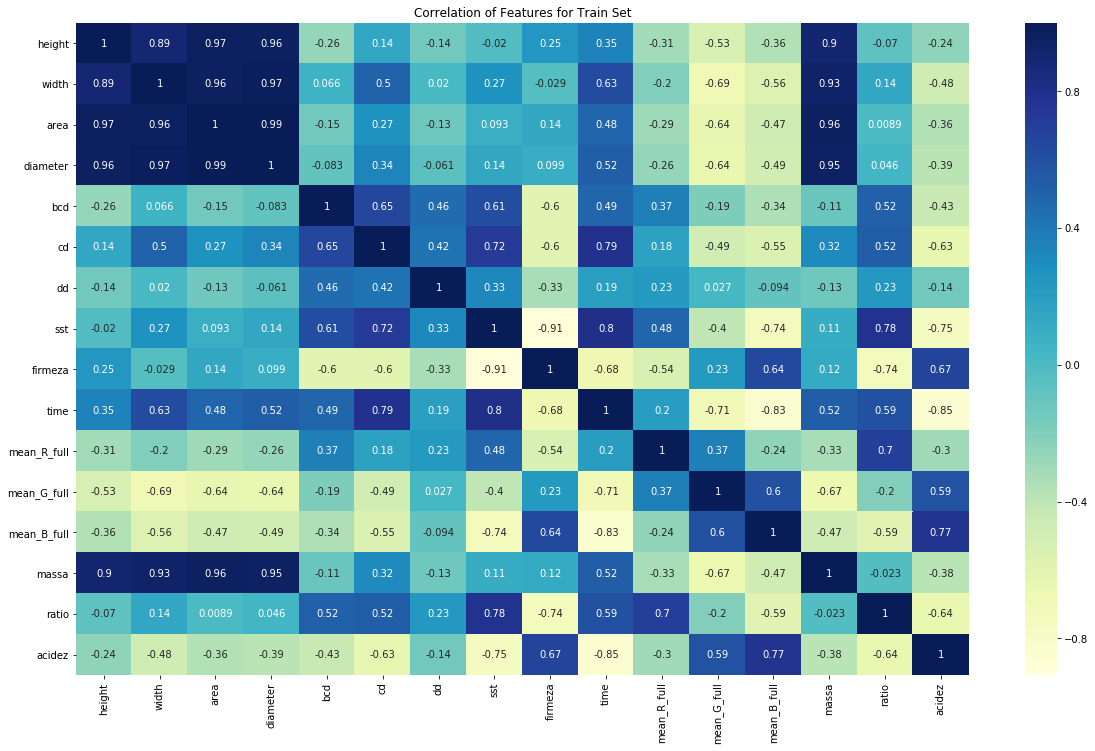

In [128]:
plt.figure(figsize=(20,12))
plt.title('Correlation of Features for Train Set')
sns.heatmap(teste.astype(float).corr(),vmax=1.0,  annot=True, cmap='YlGnBu')
plt.show()

In [132]:
n_trees = 500
kf = KFold(n_splits=5, shuffle=True)

In [ ]:
# data = pd.read_csv(path+'features//size_all_half.csv', sep=';', index_col=0)
# palmer_sst = pd.read_csv(path+'//reference_values//primeiros_dados_palmer_sst.csv', sep=';', index_col=0)
# palmer_firm = pd.read_csv(path+'//reference_values//primeiros_dados_palmer_firmeza.csv', sep=';', index_col=0)

# data['sst'] = palmer_sst.values
# data['firmeza'] = palmer_firm.values

In [133]:
X = data.drop(columns=['time', 'sst', 'firmeza', 'ratio', 'massa', 'acidez'])
Y_sst = data['sst']
Y_firm = data['firmeza']
Y_time = data['time']
Y_acidez = data['acidez']
Y_massa = data['massa']
Y_ratio = data['ratio']

In [134]:
predictions = pd.DataFrame(index=data.index.values, columns=['sst_predict', 'firmeza_predict', 'time_predict', \
                                                             'massa_predict', 'ratio_predict', 'acidez_predict'])
real = pd.DataFrame(index=data.index.values, columns=['sst_real', 'firmeza_real', 'time_real', 'massa_real', \
                                                      'ratio_real', 'acidez_real'])

In [31]:
# # execute esta célula só se for fazer análise no arquivo com todas as variáveis
# data = data.drop(columns=data.columns.values[179:])

# # adicionando novamente as médias nas 5 regiões, porque no arquivo features_all há a substituição das médias com n = 20
# data_to_add = pd.read_csv(path+'features\\rgb_hsv_lab_n_regions_all_half.csv', sep=';', index_col=0)
# data[data_to_add.columns.values] = data_to_add[data_to_add.columns.values]

In [7]:
# apenas para repetição das 60 amostras
# index = np.append(data.index.values, [str(num) for num in np.arange(60)])

# predictions = pd.DataFrame(index=index, columns=['sst_predict', 'firmeza_predict', 'time_predict'])
# real = pd.DataFrame(index=index, columns=['sst_real', 'firmeza_real', 'time_real'])

# new_data = pd.DataFrame(data.iloc[-60:].values, index=np.arange(1,61),columns=data.columns)
# data = pd.concat([data,new_data])

In [ ]:
i=1
for train_i, test_i in kf.split(X):
    print(i)
    X_train, X_test = X.iloc[train_i], X.iloc[test_i]
    Y_sst_train, __ = Y_sst.iloc[train_i], Y_sst.iloc[test_i]
    Y_firm_train, __ = Y_firm.iloc[train_i], Y_firm.iloc[test_i]
    Y_time_train, __ = Y_time.iloc[train_i], Y_time.iloc[test_i]
    Y_acidez_train, __ = Y_acidez.iloc[train_i], Y_acidez.iloc[test_i]
    Y_massa_train, __ = Y_massa.iloc[train_i], Y_massa.iloc[test_i]
    Y_ratio_train, __ = Y_ratio.iloc[train_i], Y_ratio.iloc[test_i]
    
    print('sst')
    rf_model = RandomForestRegressor(n_estimators=n_trees).fit(X_train, Y_sst_train)
    Y_predicted = rf_model.predict(X_test)
    predictions['sst_predict'].iloc[test_i] = Y_predicted
    
    print('firmeza')
    rf_model = RandomForestRegressor(n_estimators=n_trees).fit(X_train, Y_firm_train)
    Y_predicted = rf_model.predict(X_test)
    predictions['firmeza_predict'].iloc[test_i] = Y_predicted
    
    print('time')
    rf_model = RandomForestRegressor(n_estimators=n_trees).fit(X_train, Y_time_train)
    Y_predicted = rf_model.predict(X_test)
    predictions['time_predict'].iloc[test_i] = Y_predicted

    print('acidez')
    rf_model = RandomForestRegressor(n_estimators=n_trees).fit(X_train, Y_acidez_train)
    Y_predicted = rf_model.predict(X_test)
    predictions['acidez_predict'].iloc[test_i] = Y_predicted

    print('massa')
    rf_model = RandomForestRegressor(n_estimators=n_trees).fit(X_train, Y_massa_train)
    Y_predicted = rf_model.predict(X_test)
    predictions['massa_predict'].iloc[test_i] = Y_predicted

    print('ratio')
    rf_model = RandomForestRegressor(n_estimators=n_trees).fit(X_train, Y_ratio_train)
    Y_predicted = rf_model.predict(X_test)
    predictions['ratio_predict'].iloc[test_i] = Y_predicted

    i=i+1    

1
sst
firmeza
time
acidez
massa
ratio
2
sst
firmeza
time
acidez
massa
ratio


In [105]:
real['sst_real'] = data['sst']
real['firmeza_real'] = data['firmeza']
real['time_real'] = data['time']
real['massa_real'] = data['massa']
real['ratio_real'] = data['ratio']
real['acidez_real'] = data['acidez']

# real.iloc[660:] = real.iloc[-120:-60].values
# real.to_csv('real_repeated.csv', sep=',')

In [107]:
predictions.to_csv('dados_predict.csv', sep=';')
predictions['sst_real'] = real['sst_real']
predictions['firmeza_real'] = real['firmeza_real']
predictions['time_real'] = real['time_real']
predictions['acidez_real'] = real['acidez_real']
predictions['massa_real'] = real['massa_real']
predictions['ratio_real'] = real['ratio_real']

predictions.to_csv('../predictions/dados_predict_reais.csv', sep=';')

In [108]:
def calc_tabela(data, att, range_max, range_min, intervals, consider_end):
    indexes = []
    bins = math.floor((range_max-range_min)/intervals)
    tabela = pd.DataFrame(data=0,index=np.arange(bins),columns=data.columns)
    
    for bin_num in range(bins):
        min_v = range_min if bin_num == 0 else range_min + intervals*bin_num + 1
        if bin_num!=(bins-1):
            max_v = min_v + intervals if bin_num == 0 else min_v + intervals - 1
        else:
            max_v = range_max
        indexes.append(str(min_v)+'-'+str(max_v))
        tabela.iloc[bin_num] = data[(min_v<=data[att]) & (data[att]<=max_v)].mean()
    
    tabela.index = indexes
    return tabela

In [112]:
range_max = 170
range_min = 20
intervals = 15

tabela_real = calc_tabela(real, 'time_real', range_max, range_min, intervals, False)
tabela_pred = calc_tabela(predictions, 'time_predict', range_max, range_min, intervals, False)

In [115]:
tabela_pred[tabela_pred.columns[:6]]

,sst_predict,firmeza_predict,time_predict,massa_predict,ratio_predict,acidez_predict
20-35,4.827728,93.802218,35.000000,62.502005,3.562595,1.600073
36-50,5.140771,113.656947,49.481273,178.881566,3.024696,1.776334
51-65,5.267593,124.045111,62.947778,276.139828,3.521026,1.586323
66-80,5.391565,126.864906,70.982353,341.138412,3.846342,1.554024
81-95,5.770459,130.263291,87.010556,467.733381,6.620054,1.570580
96-110,5.655777,142.739892,103.674675,514.565014,5.574463,1.126549
111-125,5.844988,141.060235,117.162941,537.366744,6.658038,0.912160
126-140,6.106348,142.751926,134.398154,538.846372,8.620825,0.768309
141-155,6.516836,134.552236,148.350667,576.299696,12.656503,0.702543
156-170,7.819877,107.684298,161.571000,561.369182,27.595348,0.603549


In [116]:
range_max = 190
range_min = 171
intervals = 9

tabela_real = calc_tabela(real, 'time_real', range_max, range_min, intervals, True)
tabela_pred = calc_tabela(predictions, 'time_predict', range_max, range_min, intervals, True)

In [118]:
tabela_pred[tabela_pred.columns[:6]]

,sst_predict,firmeza_predict,time_predict,massa_predict,ratio_predict,acidez_predict
171-180,12.151184,39.310996,178.855213,461.520362,42.566102,0.529442
181-190,15.008913,7.701498,188.391829,427.402895,214.460590,0.085886


In [32]:
tabela_real

,sst_real,firmeza_real,time_real
171-180,12.824,28.732333,180.0
181-190,14.950,6.035500,190.0
